In [1]:
import os
import pathlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler
import statsmodels.stats.multitest

/projects/b1196/envs/serniczek/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.lm-Widget {overflow-x: scroll !important;}
</style>
"""))

In [3]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

# HALLMARK gene sets enrichment in DEGs

We want a heatmap: 
- rows are HALLMARK processes
- columns are cell-type-comparisons
- values are -log10 enrichment p-value

In [4]:
msigdb = decoupler.get_resource('MSigDB', organism='human')

In [5]:
hallmark = msigdb[msigdb.collection.eq('hallmark')]

In [6]:
hallmark = hallmark[~hallmark.duplicated(['geneset', 'genesymbol'])]

function that makes a dict for all cell types participating in comparison and then adds DEGs that match criteria

In [9]:
def load_degs(base_path, baseMean=100):
    result = {}
    for path in base_path.glob('**/degs_with_stats.csv'):
        cell_type = path.parts[-2]
        comparison = path.parts[-4]
        
        df = pd.read_csv(path, index_col=0)
        # Filter genes based on specified criteria
        filtered_genes = df[
            (df['baseMean'] > baseMean)
        ]
        # Extract gene names meeting the criteria
        # gene_list = filtered_genes.index.tolist()
        result.setdefault(comparison, {})[cell_type] = filtered_genes
    return result

In [10]:
degs = load_degs(
    pathlib.Path("/projects/b1038/Pulmonary/sbratchikov/Projects/SCRIPT/traditional/DGEs/DEG/")
)

In [11]:
degs['Healthy_SARS-CoV-2_fixed']['nupr1+_macs']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,sign,n_cells_control,n_cells_condition,%_pseudobulks_control,total_n_pseudobulks_control,%_pseudobulks_condition,total_n_pseudobulks_condition
FOLR3,371.051071,4.760880,0.550945,8.641294,5.557998e-18,9.488614e-16,Upregulated,31474,7426,100.000000,9,92.857143,92.857143
HP,387.050223,3.301443,0.725783,4.548800,5.395279e-06,5.675182e-05,Upregulated,33753,7511,100.000000,9,89.285714,89.285714
IGF1,115.558944,2.778891,1.082712,2.566602,1.027005e-02,3.127546e-02,Upregulated,8517,1463,100.000000,9,67.857143,67.857143
CAMP,102.950170,2.540507,0.479451,5.298781,1.165782e-07,2.124387e-06,Upregulated,9811,3301,100.000000,9,96.428571,96.428571
ITIH5,102.985321,2.414829,1.067007,2.263181,2.362456e-02,6.036622e-02,NaN,15042,2875,88.888889,9,67.857143,67.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
IL1R2,120.110771,-8.648354,0.820952,-10.534549,5.986984e-26,2.620764e-23,Downregulated,31,2359,77.777778,9,96.428571,96.428571
IGHG1,116.200454,-9.762607,1.309233,-7.456738,8.869095e-14,7.244650e-12,Downregulated,13,1854,55.555556,9,67.857143,67.857143
SPP1,2094.976655,-9.911779,0.589651,-16.809580,2.076362e-63,3.544766e-59,Downregulated,105,10827,100.000000,9,100.000000,100.000000
ADAMTS2,176.548731,-12.245779,0.832654,-14.706924,5.819326e-49,3.311584e-45,Downregulated,3,8689,22.222222,9,100.000000,100.000000


In [16]:
result = []
for comparison, cell_types in degs.items():
    for cell_type, genes in cell_types.items():
        if genes.shape[0] <= 9:
            continue
        enriched = decoupler.get_gsea_df(
            df=genes,
            stat='log2FoldChange',
            net=hallmark,
            source='geneset',
            target='genesymbol',
            seed=1066
        )
        enriched['comparison'] = comparison
        enriched['cell_type'] = cell_type
        enriched['n_genes'] = len(genes)
        result.append(enriched)

In [17]:
result = pd.concat(result)

Remove exactly `0` p-values (improbable), set them to minimum p-value times 10e-3.

TODO: add more perturbations to running GSEA (default is 1000 times)

In [48]:
idx = result['NOM p-value'].eq(0)
min_p_val = result['NOM p-value'][~idx].min()
result.loc[idx, 'NOM p-value'] = min_p_val * 0.001

In [50]:
result['padj'] = statsmodels.stats.multitest.fdrcorrection(result['NOM p-value'])[1]

In [51]:
result['-log10(padj)'] = -np.log10(result.padj)

In [52]:
result['-log10(padj)'] *= np.sign(result.NES)

In [53]:
result['group'] = result.comparison + '/' + result.cell_type

In [54]:
result_df = result.pivot_table(
    index='group',
    columns='Term',
    values='-log10(padj)'
)

In [55]:
col_ann = result[['comparison', 'cell_type', 'group']].drop_duplicates()

In [56]:
col_ann['control'] = col_ann.comparison.str.split('_').str[0]

In [57]:
col_ann['pathogen'] = col_ann.comparison.str.split('_').str[1:].str.join('_')

In [58]:
col_ann.pathogen = col_ann.pathogen.replace({
    'SARS-CoV-2_fixed': 'SARS-CoV-2',
    'Pseudomonas_aeruginosa': 'Pseudomonas',
    'Pseudomonas_aeruginosa_SARS-CoV-2': 'Pseudomonas_SARS-CoV-2'
})

In [59]:
col_ann['is_covid'] = pd.Categorical(
    col_ann.pathogen.str.contains('SARS-CoV-2', regex=False), 
    categories=[False, True]
)
col_ann['is_gram+'] = pd.Categorical(
    col_ann.pathogen.str.contains('Gram+', regex=False),
    categories=[False, True]
)
col_ann['is_gram-'] = pd.Categorical(
    col_ann.pathogen.str.contains('Gram-', regex=False),
    categories=[False, True]
)
col_ann['is_pseudomonas'] = pd.Categorical(
    col_ann.pathogen.str.contains('Pseudomonas', regex=False),
    categories=[False, True]
)

In [60]:
col_ann.set_index('group', inplace=True)

In [61]:
col_colors = get_color_annotations(col_ann, {
    'control': ['lightskyblue', 'steelblue'],
    # 'pathogen': 'Set2',
    'is_covid': ['white', 'lightcoral'],
    'is_gram+': ['white', 'olive'],
    'is_gram-': ['white', 'darkgoldenrod'],
    'is_pseudomonas': ['white', 'plum'],
    'cell_type': 'tab20'
})

In [62]:
col_colors2 = get_color_annotations(col_ann, {
    'control': ['lightskyblue', 'steelblue'],
    'pathogen': 'Set2',
    'cell_type': 'tab20'
})

In [63]:
legend_handles = {}
for l in ('control', 'cell_type'):
    legend_handles[l] = []
    labels = col_ann[[l]].drop_duplicates().sort_values(l)
    colors = col_colors.loc[labels.index, l]
    for label, color in zip(labels[l], colors):
        legend_handles[l].append(mpl.patches.Patch(
            label=label,
            color=color
        ))

In [64]:
legend_handles2 = {}
for l in ('control', 'pathogen', 'cell_type'):
    legend_handles2[l] = []
    labels = col_ann[[l]].drop_duplicates().sort_values(l)
    colors = col_colors2.loc[labels.index, l]
    for label, color in zip(labels[l], colors):
        legend_handles2[l].append(mpl.patches.Patch(
            label=label,
            color=color
        ))

In [65]:
n_genes = result[['group', 'n_genes']].drop_duplicates('group').set_index('group').n_genes[
    result_df.index
]

In [66]:
result_df_plot = result_df.fillna(0).T

In [67]:
def count_n_cell_types_with_diff_pathogen_results(pathway):
    result = []
    control = col_ann.control[pathway.index]
    for c in ['Healthy', 'NPC']:
        c_pathway = pathway[control.eq(c)]
        c_cell_type = col_ann.cell_type[c_pathway.index]
        n_groups_with_diff_pathogen_results = c_pathway.abs().gt(
            -np.log10(0.05)
        ).groupby(c_cell_type).nunique().eq(2).sum()
        result.append(f'{c[0]}:{n_groups_with_diff_pathogen_results}')
    return '; '.join(result)
pathway_suffixes = result_df_plot.apply(count_n_cell_types_with_diff_pathogen_results, axis=1)

In [68]:
pathway_suffixes.replace('H:0; N:0', '', inplace=True)

In [69]:
pathway_suffixes[pathway_suffixes.ne('')] = '*** (' + pathway_suffixes[pathway_suffixes.ne('')] + ')'

In [70]:
rownames = result_df.columns.str.replace('HALLMARK_', '') + pathway_suffixes

In [71]:
row_colors = pd.DataFrame(index=result_df.columns)
row_colors['signif'] = 'white'
row_colors.signif[pathway_suffixes.ne('').values] = 'teal'

In [72]:
stars = np.empty_like(result_df_plot, dtype=str)
stars[result_df_plot.abs().gt(-np.log10(0.05))] = '*'

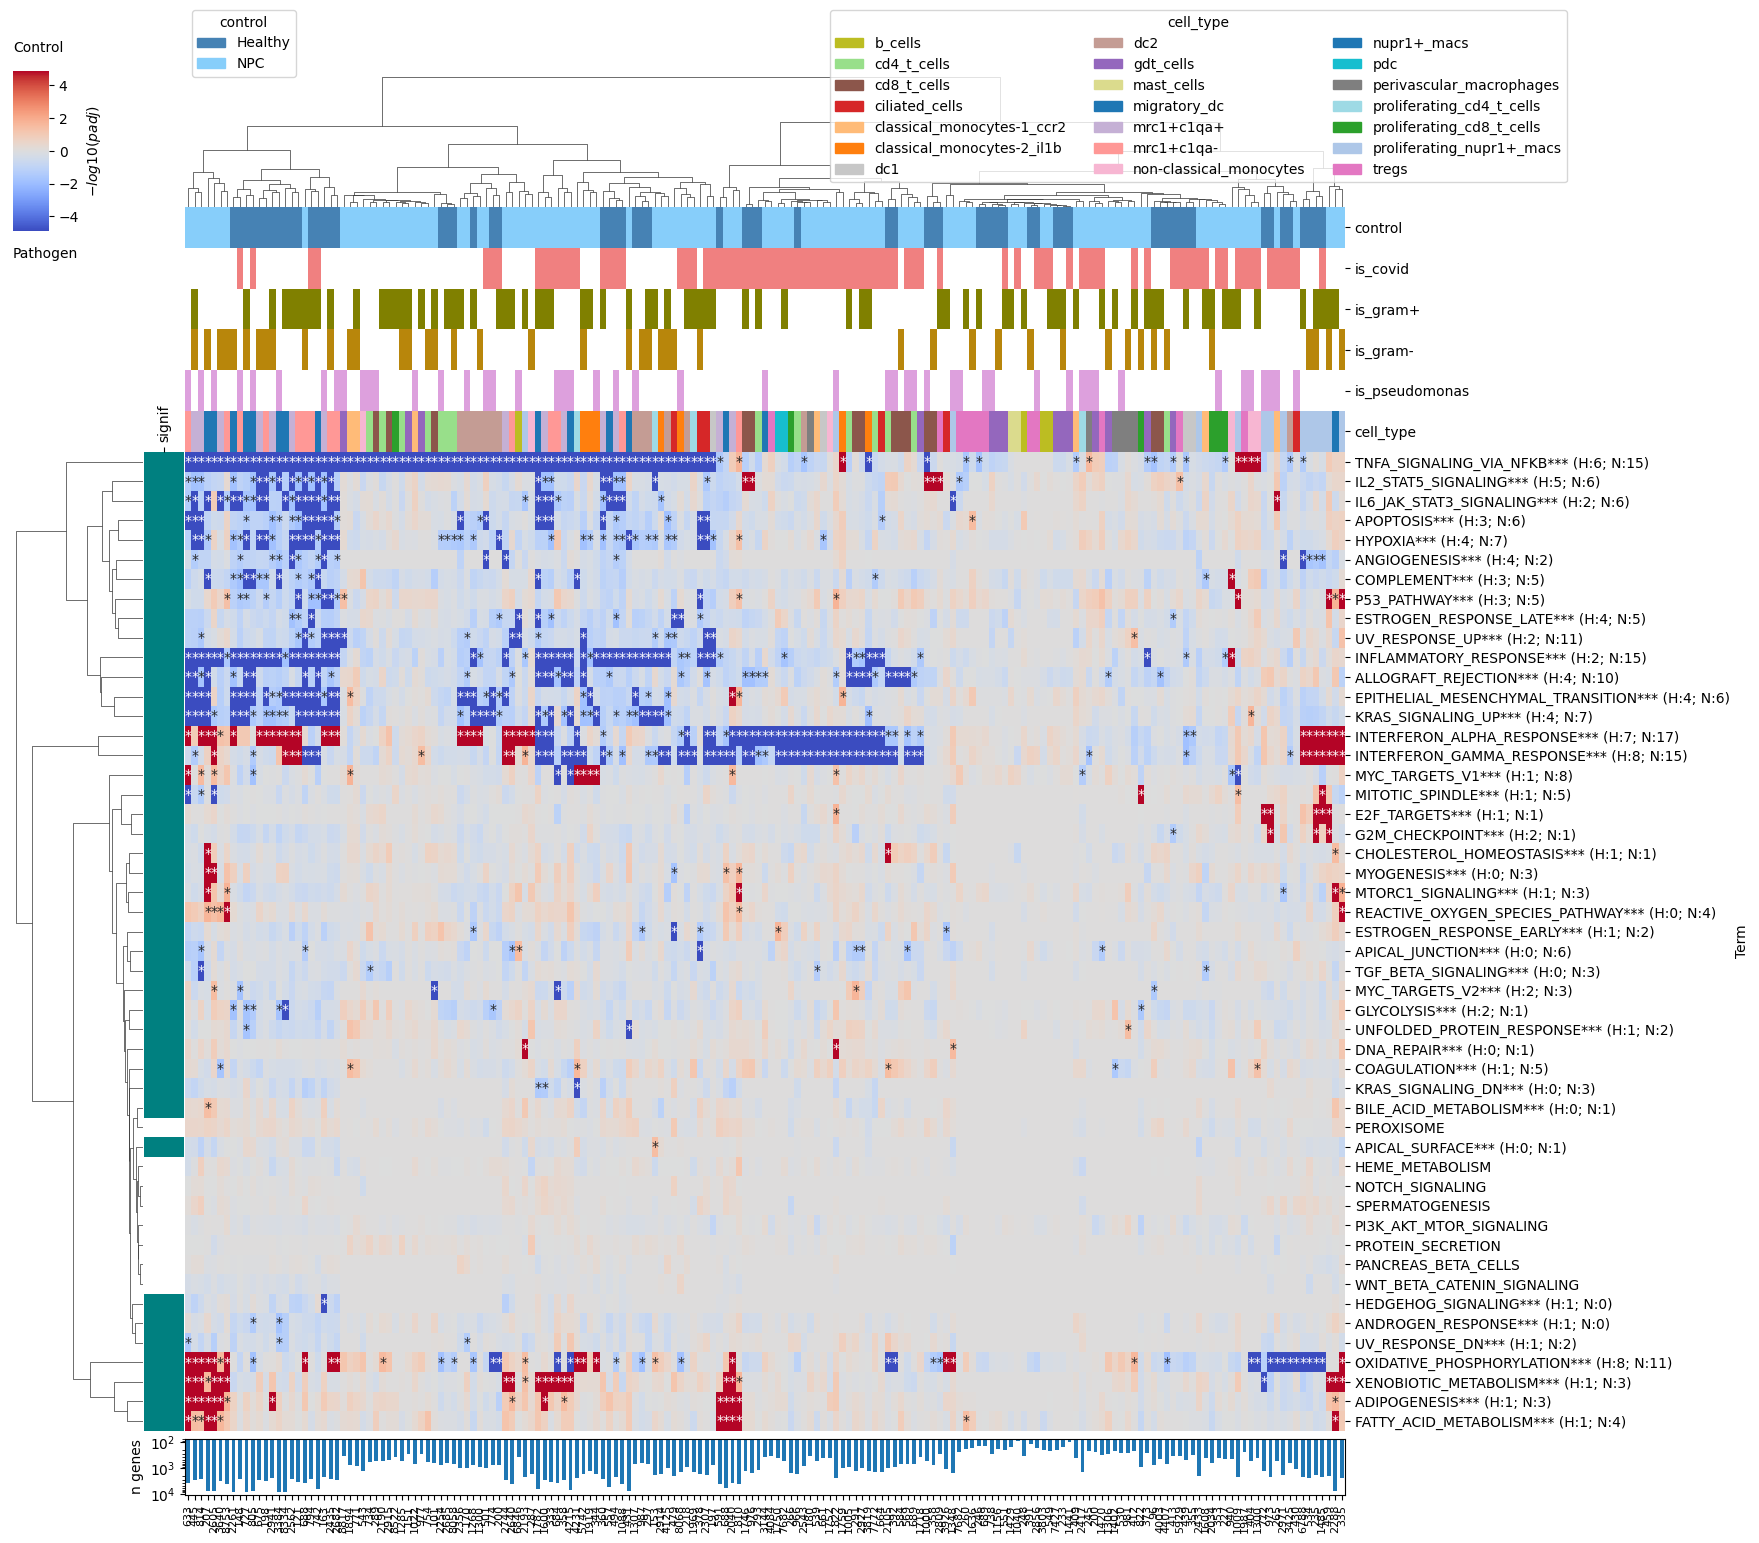

In [85]:
cg = sns.clustermap(
    result_df_plot,
    col_colors=col_colors,
    row_colors=row_colors,
    method='ward',
    figsize=(18, 16),
    dendrogram_ratio=0.1,
    cbar_pos=(0.01, 0.85, 0.02, 0.1),
    cbar_kws=dict(
        label='$-log10(padj)$'
    ),
    xticklabels=[],
    yticklabels=rownames,
    cmap='coolwarm',
    annot=stars,
    fmt=''
)
cg.ax_cbar.annotate('Pathogen', (0, -0.1), xycoords='axes fraction', va='top')
cg.ax_cbar.annotate('Control', (0, 1.1), xycoords='axes fraction', va='bottom')
legend_offsets = (0, 0.55)
for (label, handles), offset_x in zip(legend_handles.items(), legend_offsets):
    ncols = 1
    if len(handles) > 3:
        ncols = 2
    if len(handles) > 10:
        ncols = 3
    l = cg.ax_col_dendrogram.legend(
        handles=handles, 
        title=label,
        ncols=ncols,
        bbox_to_anchor=(offset_x, 1.5),
        loc='upper left'
    )
    if offset_x != legend_offsets[-1]:
        cg.ax_col_dendrogram.add_artist(l)

cg.ax_row_colors.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, rotation=90)
cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_heatmap.set_xlabel('')
cg.ax_col_dendrogram.figure.subplots_adjust(bottom=0.1, top=0.95, right=0.75)
p = cg.ax_heatmap.get_position()
p.y1 = p.y0 - 0.005
p.y0 -= 0.04
n_genes_ax = cg.ax_heatmap.figure.add_axes(p)
n_genes_ax.bar(
    np.array(range(len(n_genes))) + 0.5,
    n_genes[cg.dendrogram_col.reordered_ind],
    log=True,
    width=0.6
)
n_genes_ax.invert_yaxis()
n_genes_ax.set_xlim(cg.ax_heatmap.get_xlim())
n_genes_ax.set_xticks(np.array(range(len(n_genes))) + 0.5, labels=n_genes, rotation=90, fontsize=8)
n_genes_ax.set_ylabel('n genes')
cg.ax_cbar.set_position((0.01, 0.85, 0.02, 0.1))
cg.ax_col_dendrogram.figure.savefig('04_pathogen_hallmark_gsea_clustered.pdf', dpi=300)

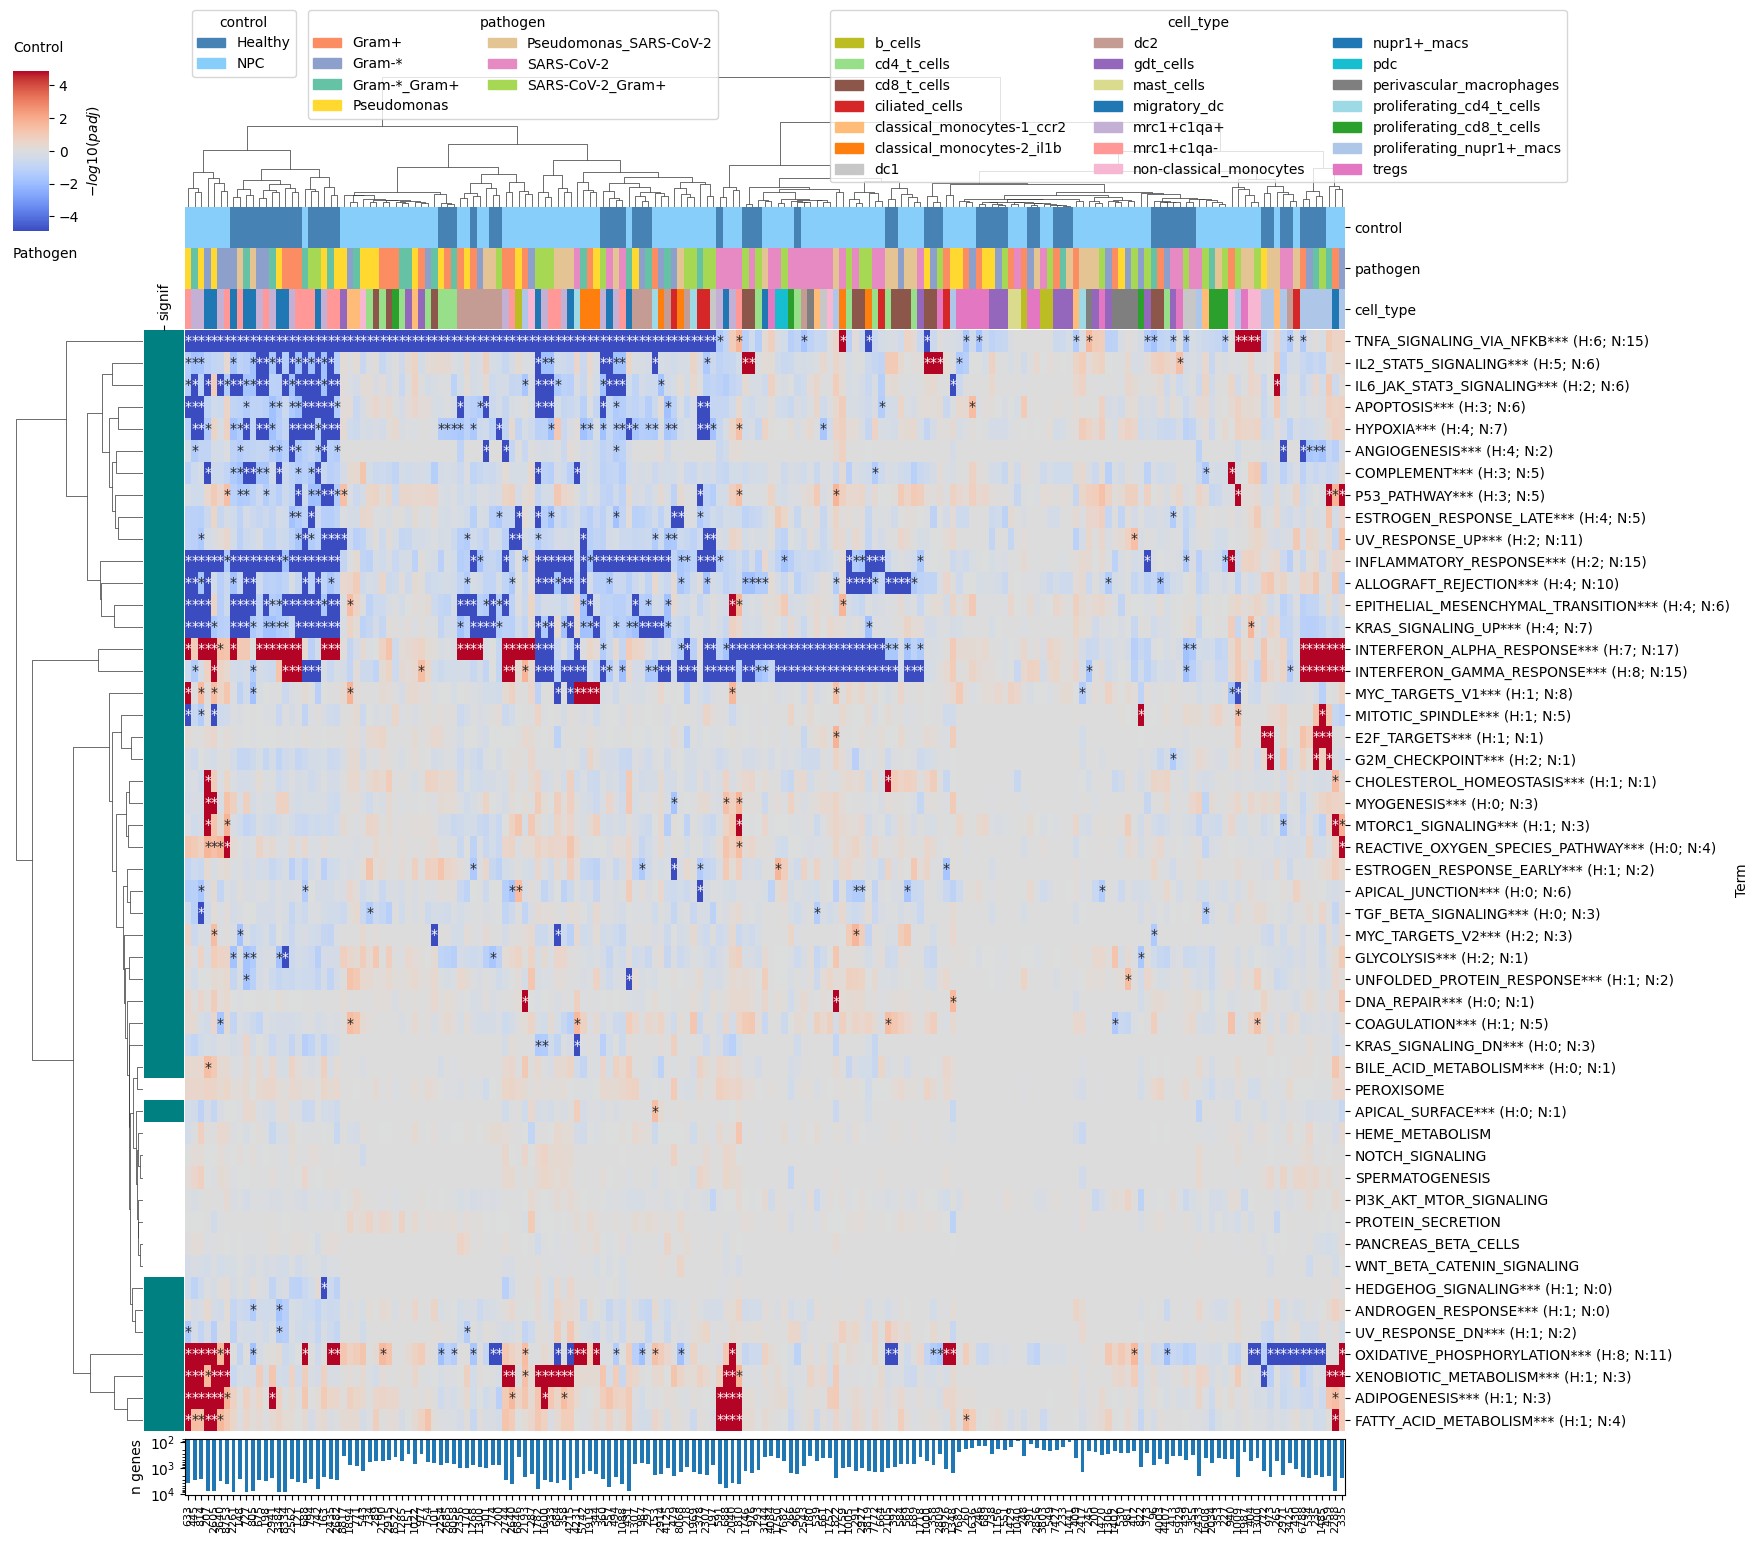

In [87]:
cg = sns.clustermap(
    result_df_plot,
    col_colors=col_colors2,
    row_colors=row_colors,
    method='ward',
    figsize=(18, 16),
    dendrogram_ratio=0.1,
    cbar_pos=(0.01, 0.85, 0.02, 0.1),
    cbar_kws=dict(
        label='$-log10(padj)$'
    ),
    xticklabels=[],
    yticklabels=rownames,
    cmap='coolwarm',
    annot=stars,
    fmt=''
)
cg.ax_cbar.annotate('Pathogen', (0, -0.1), xycoords='axes fraction', va='top')
cg.ax_cbar.annotate('Control', (0, 1.1), xycoords='axes fraction', va='bottom')
legend_offsets2 = (0, 0.1, 0.55)
for (label, handles), offset_x in zip(legend_handles2.items(), legend_offsets2):
    ncols = 1
    if len(handles) > 3:
        ncols = 2
    if len(handles) > 10:
        ncols = 3
    l = cg.ax_col_dendrogram.legend(
        handles=handles, 
        title=label,
        ncols=ncols,
        bbox_to_anchor=(offset_x, 1.5),
        loc='upper left'
    )
    if offset_x != legend_offsets2[-1]:
        cg.ax_col_dendrogram.add_artist(l)

cg.ax_row_colors.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, rotation=90)
cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_heatmap.set_xlabel('')
cg.ax_col_dendrogram.figure.subplots_adjust(bottom=0.1, top=0.95, right=0.75)
p = cg.ax_heatmap.get_position()
p.y1 = p.y0 - 0.005
p.y0 -= 0.04
n_genes_ax = cg.ax_heatmap.figure.add_axes(p)
n_genes_ax.bar(
    np.array(range(len(n_genes))) + 0.5,
    n_genes[cg.dendrogram_col.reordered_ind],
    log=True,
    width=0.6
)
n_genes_ax.invert_yaxis()
n_genes_ax.set_xlim(cg.ax_heatmap.get_xlim())
n_genes_ax.set_xticks(np.array(range(len(n_genes))) + 0.5, labels=n_genes, rotation=90, fontsize=8)
n_genes_ax.set_ylabel('n genes')
cg.ax_cbar.set_position((0.01, 0.85, 0.02, 0.1))
cg.ax_col_dendrogram.figure.savefig('04_pathogen_hallmark_gsea_clustered_2.pdf', dpi=300)

In [88]:
col_order = col_ann.sort_values([
    'control', 'cell_type', 'is_covid', 'is_gram+', 'is_gram-', 'is_pseudomonas'
]).index

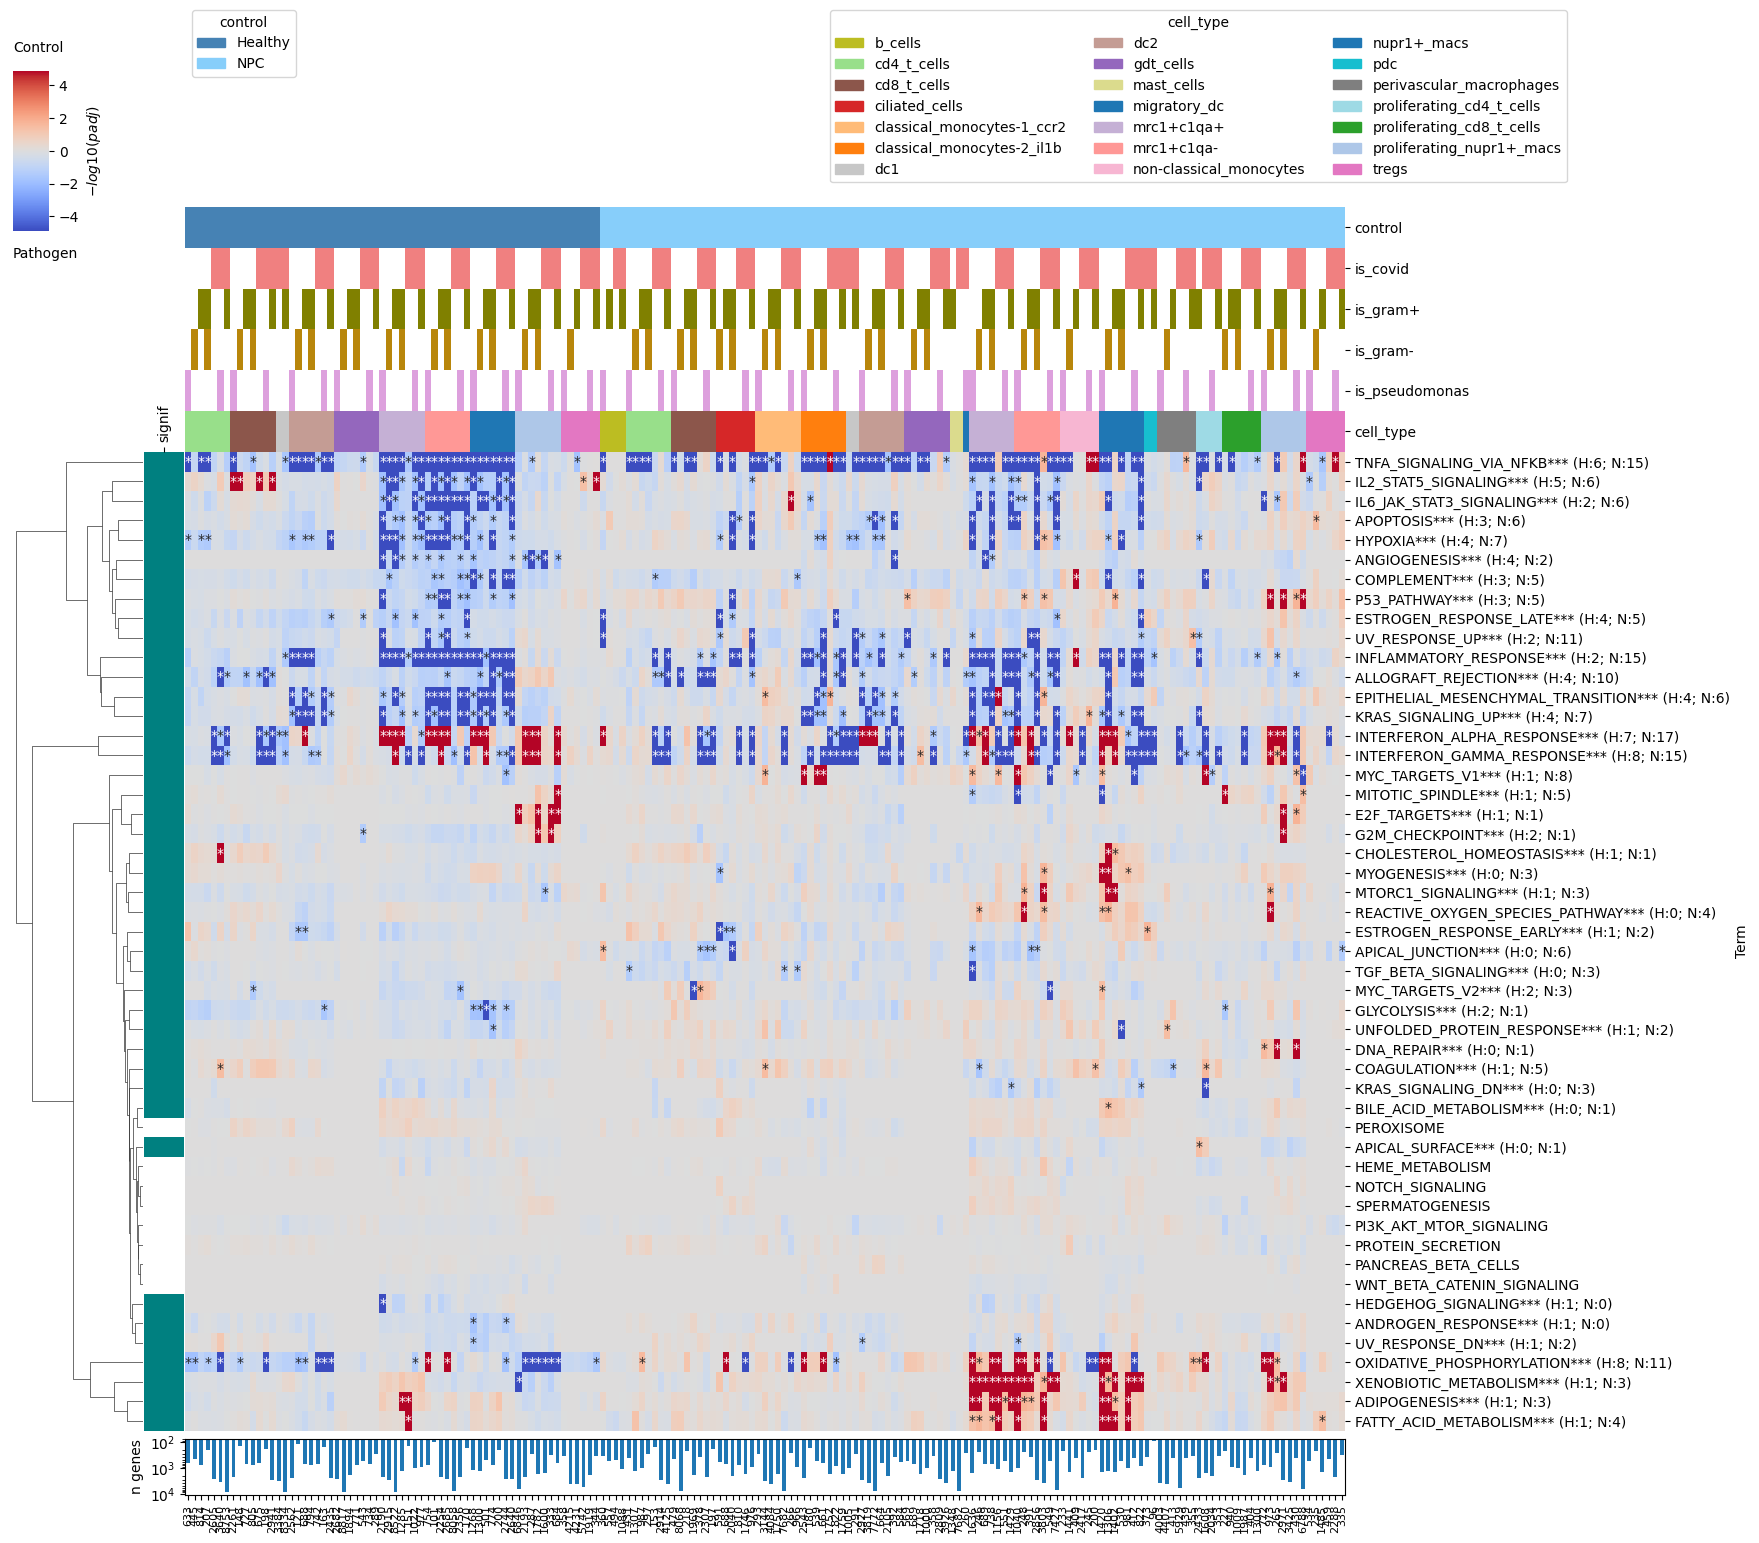

In [90]:
cg = sns.clustermap(
    result_df.loc[col_order].fillna(0).T,
    col_colors=col_colors,
    row_colors=row_colors,
    method='ward',
    figsize=(18, 16),
    dendrogram_ratio=0.1,
    cbar_pos=(0.01, 0.85, 0.02, 0.1),
    cbar_kws=dict(
        label='$-log10(padj)$'
    ),
    xticklabels=[],
    yticklabels=rownames,
    cmap='coolwarm',
    annot=pd.DataFrame(stars, columns=result_df.index).loc[:, col_order],
    fmt='',
    col_cluster=False
)
cg.ax_cbar.annotate('Pathogen', (0, -0.1), xycoords='axes fraction', va='top')
cg.ax_cbar.annotate('Control', (0, 1.1), xycoords='axes fraction', va='bottom')
legend_offsets = (0, 0.55)
for (label, handles), offset_x in zip(legend_handles.items(), legend_offsets):
    ncols = 1
    if len(handles) > 3:
        ncols = 2
    if len(handles) > 10:
        ncols = 3
    l = cg.ax_col_dendrogram.legend(
        handles=handles, 
        title=label,
        ncols=ncols,
        bbox_to_anchor=(offset_x, 1.5),
        loc='upper left'
    )
    if offset_x != legend_offsets[-1]:
        cg.ax_col_dendrogram.add_artist(l)

cg.ax_row_colors.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, rotation=90)
cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_heatmap.set_xlabel('')
cg.ax_col_dendrogram.figure.subplots_adjust(bottom=0.1, top=0.95, right=0.75)
p = cg.ax_heatmap.get_position()
p.y1 = p.y0 - 0.005
p.y0 -= 0.04
n_genes_ax = cg.ax_heatmap.figure.add_axes(p)
n_genes_ax.bar(
    np.array(range(len(n_genes))) + 0.5,
    n_genes,
    log=True,
    width=0.6
)
n_genes_ax.invert_yaxis()
n_genes_ax.set_xlim(cg.ax_heatmap.get_xlim())
n_genes_ax.set_xticks(np.array(range(len(n_genes))) + 0.5, labels=n_genes, rotation=90, fontsize=8)
n_genes_ax.set_ylabel('n genes')
cg.ax_cbar.set_position((0.01, 0.85, 0.02, 0.1))
cg.ax_col_dendrogram.figure.savefig('04_pathogen_hallmark_gsea_ordered.pdf', dpi=300)

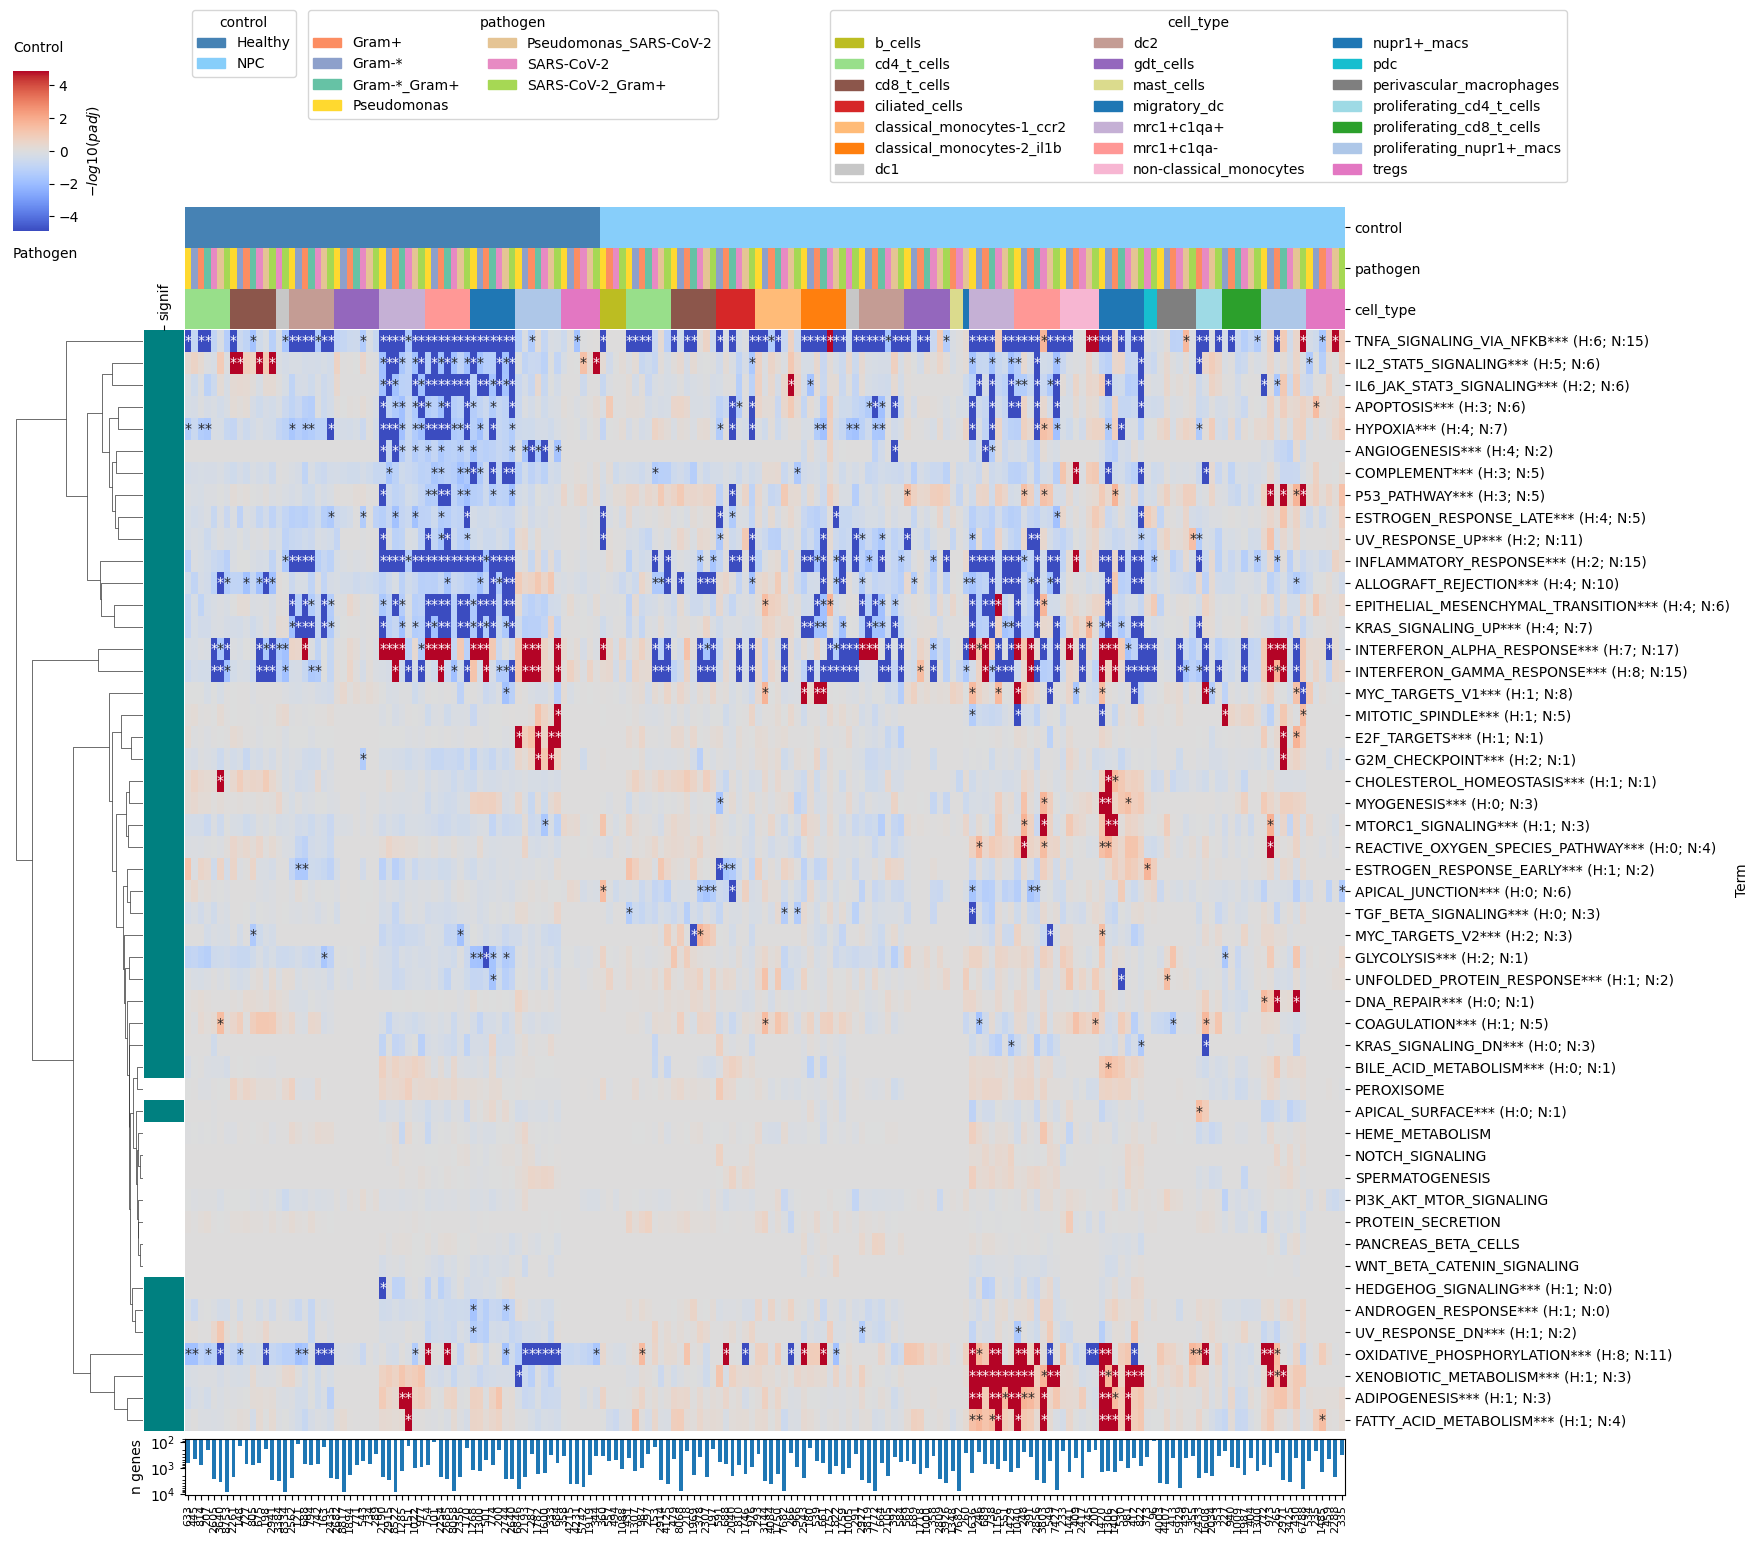

In [91]:
cg = sns.clustermap(
    result_df.loc[col_order].fillna(0).T,
    col_colors=col_colors2,
    row_colors=row_colors,
    method='ward',
    figsize=(18, 16),
    dendrogram_ratio=0.1,
    cbar_pos=(0.01, 0.85, 0.02, 0.1),
    cbar_kws=dict(
        label='$-log10(padj)$'
    ),
    xticklabels=[],
    yticklabels=rownames,
    cmap='coolwarm',
    annot=pd.DataFrame(stars, columns=result_df.index).loc[:, col_order],
    fmt='',
    col_cluster=False
)
cg.ax_cbar.annotate('Pathogen', (0, -0.1), xycoords='axes fraction', va='top')
cg.ax_cbar.annotate('Control', (0, 1.1), xycoords='axes fraction', va='bottom')
for (label, handles), offset_x in zip(legend_handles2.items(), legend_offsets2):
    ncols = 1
    if len(handles) > 3:
        ncols = 2
    if len(handles) > 10:
        ncols = 3
    l = cg.ax_col_dendrogram.legend(
        handles=handles, 
        title=label,
        ncols=ncols,
        bbox_to_anchor=(offset_x, 1.5),
        loc='upper left'
    )
    if offset_x != legend_offsets2[-1]:
        cg.ax_col_dendrogram.add_artist(l)

cg.ax_row_colors.tick_params(bottom=False, labelbottom=False, top=True, labeltop=True, rotation=90)
cg.ax_col_colors.collections[0].set_rasterized(True)
cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_heatmap.set_xlabel('')
cg.ax_col_dendrogram.figure.subplots_adjust(bottom=0.1, top=0.95, right=0.75)
p = cg.ax_heatmap.get_position()
p.y1 = p.y0 - 0.005
p.y0 -= 0.04
n_genes_ax = cg.ax_heatmap.figure.add_axes(p)
n_genes_ax.bar(
    np.array(range(len(n_genes))) + 0.5,
    n_genes,
    log=True,
    width=0.6
)
n_genes_ax.invert_yaxis()
n_genes_ax.set_xlim(cg.ax_heatmap.get_xlim())
n_genes_ax.set_xticks(np.array(range(len(n_genes))) + 0.5, labels=n_genes, rotation=90, fontsize=8)
n_genes_ax.set_ylabel('n genes')
cg.ax_cbar.set_position((0.01, 0.85, 0.02, 0.1))
cg.ax_col_dendrogram.figure.savefig('04_pathogen_hallmark_gsea_ordered_2.pdf', dpi=300)